In [2]:
from random import shuffle
from typing import List, Literal, Optional, Tuple
import math, heapq

UP = 'up'
DOWN = 'down'
LEFT = 'left'
RIGHT = 'right'

Move = Literal['up', 'down', 'left', 'right']
Solution = List[Move]
State = List[int]

def index_to_coords(index: int, dimension: int) -> tuple[int, int]:
    """ Convertit un index i d'une liste de taille dimension**2 en coordonnées (x, y) dans un tableau 2D de taille dimension x dimension."""
    i = index // dimension
    j = index % dimension
    return i, j

def coords_to_index(i: int, j: int, dimension: int) -> int:
    """ Convertit des coordonnées (i, j) en index dans une liste de taille dimension**2 """
    return i * dimension + j

def is_solvable(puzzle: State) -> bool:
    """ Check if the puzzle is solvable """
    dimension = int(math.sqrt(len(puzzle)))
    puzzle_without_blank = [element for element in puzzle if element != 0]
    inversion_count = 0
    for i in range(len(puzzle_without_blank) - 1):
        for j in range(i + 1, len(puzzle_without_blank)):
            if puzzle_without_blank[i] > puzzle_without_blank[j]:
                inversion_count += 1

    if dimension % 2 == 1:
        return inversion_count % 2 == 0
    else:
        blank_position = puzzle.index(0)

        blank_row = blank_position // dimension
        blank_row_from_bottom = dimension - blank_row
        return (inversion_count % 2 == 0) == (blank_row_from_bottom % 2 == 1)

def create_goal(dimension: int) -> State:
    """ Create the goal state of the puzzle """
    return [i for i in range(1, dimension ** 2)] + [0]
    
def is_goal(puzzle: State) -> bool:
    """Check if the puzzle is the goal state"""
    return create_goal(int(math.sqrt(len(puzzle)))) == puzzle   
     
def generate(dimension: int) -> State:
    """ Generate a random n-puzzle """
    init_state: State = [i for i in range(dimension ** 2)]
    while True:
        shuffle(init_state)
        if is_solvable(init_state):
            break
    return init_state

def move(puzzle: State, direction: Move) -> Optional[State]:
    """ Move the blank tile in the puzzle """
    dimension = int(math.sqrt(len(puzzle)))

    current_state = puzzle.copy()
    blank_index = current_state.index(0)
    i, j = index_to_coords(blank_index, dimension)
    target_index = None

    if direction == UP:
        if i - 1 < 0: 
            return None
        target_index = coords_to_index(i - 1, j, dimension)
    elif direction == DOWN:
        if i + 1 >= dimension: 
            return None
        target_index = coords_to_index(i + 1, j, dimension)
    elif direction == LEFT:
        if j - 1 < 0: 
            return None
        target_index = coords_to_index(i, j - 1, dimension)
    elif direction == RIGHT:
        if j + 1 >= dimension: 
            return None
        target_index = coords_to_index(i, j + 1, dimension)

    current_state[blank_index], current_state[target_index] = current_state[target_index], current_state[blank_index]
    return current_state

def get_neighbors(puzzle: State) -> List[Optional[State]]:
    """ Get the neighbors of the puzzle """
    state_list = []
    for direction in [UP, DOWN, LEFT, RIGHT]:
        new_state = move(puzzle, direction)
        state_list.append(new_state)
    return state_list

def solve_bfs(puzzle: State) -> Solution:
    """ Solve the puzzle using the BFS algorithm """
    if not is_solvable(puzzle):
        print("Non solvable !")
        return []

    visited = set()
    visited.add(tuple(puzzle))  # Mark initial state as visited
    queue = [(puzzle, [])]
    
    while queue:
        current_state, path = queue.pop(0)
        if is_goal(current_state):
            return path

        for state, direction in zip(get_neighbors(current_state), [UP, DOWN, LEFT, RIGHT]):
            if state is None: 
                continue
            state_tuple = tuple(state)
            if state_tuple not in visited:
                visited.add(state_tuple)
                updated_path = path.copy()
                updated_path.append(direction)
                queue.append((state, updated_path))
    return []

def solve_dfs(puzzle: State) -> Solution:
    """ Solve the puzzle using the DFS algorithm """
    if not is_solvable(puzzle):
        print("Non solvable !")
        return []

    stack = [(puzzle, [])]
    visited = set()
    visited.add(tuple(puzzle))  # Mark initial state as visited
    
    while stack:
        current_state, path = stack.pop()
        
        if is_goal(current_state):
            return path

        for state, direction in zip(get_neighbors(current_state), [UP, DOWN, LEFT, RIGHT]):
            if state is None: 
                continue
            state_tuple = tuple(state)
            if state_tuple not in visited:
                visited.add(state_tuple)
                updated_path = path.copy()
                updated_path.append(direction)
                stack.append((state, updated_path))
    return []
    
def heuristic(puzzle: State) -> int:
    """ Calculate Manhattan distance heuristic """
    total_distance = 0
    dimension = int(math.sqrt(len(puzzle)))
    
    for i in range(len(puzzle)):
        if puzzle[i] == 0:  # Skip the blank tile
            continue
            
        # Get current position
        current_x, current_y = index_to_coords(i, dimension)
        
        # Get target position for this value
        value = puzzle[i]
        target_pos = value - 1  # Adjust for 0-indexing
        target_x, target_y = index_to_coords(target_pos, dimension)
        
        # Add Manhattan distance
        total_distance += abs(current_x - target_x) + abs(current_y - target_y)
        
    return total_distance
    
def solve_astar(puzzle: State) -> Solution:
    """ Solve the puzzle using the A* algorithm """
    if not is_solvable(puzzle):
        print("Non solvable !")
        return []

    priority_queue = []
    initial_priority = heuristic(puzzle)
    heapq.heappush(priority_queue, (initial_priority, 0, puzzle, []))  # priority, move_count, state, path

    visited = set()
    visited.add(tuple(puzzle))
    
    while priority_queue:
        _, move_count, current_state, path = heapq.heappop(priority_queue)

        if is_goal(current_state):
            return path

        for state, direction in zip(get_neighbors(current_state), [UP, DOWN, LEFT, RIGHT]):
            if state is None: 
                continue
                
            state_tuple = tuple(state)
            if state_tuple not in visited:
                visited.add(state_tuple)
                new_path = path + [direction]
                new_move_count = move_count + 1
                priority = heuristic(state) + new_move_count
                heapq.heappush(priority_queue, (priority, new_move_count, state, new_path))
                
    return []

In [5]:
def generate_by_scrambling(dimension: int, scramble_moves: int) -> State:
    """
    Génère un puzzle à partir de l'état final en appliquant un certain nombre de mouvements valides.
    Le nombre de mouvements appliqués correspond à la difficulté.
    """
    state = create_goal(dimension)
    previous_move = None
    move_opposites = {UP: DOWN, DOWN: UP, LEFT: RIGHT, RIGHT: LEFT}
    
    for _ in range(scramble_moves):
        possible_moves = [m for m in [UP, DOWN, LEFT, RIGHT] if m != move_opposites.get(previous_move)]
        shuffle(possible_moves)
        for move_dir in possible_moves:
            new_state = move(state, move_dir)
            if new_state:
                state = new_state
                previous_move = move_dir
                break
    return state

Génération du puzzle 2*2 avec difficulté (mouvements appliqués) : 1
Génération du puzzle 2*2 avec difficulté (mouvements appliqués) : 3
Génération du puzzle 2*2 avec difficulté (mouvements appliqués) : 5
Génération du puzzle 2*2 avec difficulté (mouvements appliqués) : 7
Génération du puzzle 2*2 avec difficulté (mouvements appliqués) : 10
Génération du puzzle 2*2 avec difficulté (mouvements appliqués) : 12
Génération du puzzle 2*2 avec difficulté (mouvements appliqués) : 15
Génération du puzzle 2*2 avec difficulté (mouvements appliqués) : 18
Génération du puzzle 2*2 avec difficulté (mouvements appliqués) : 22
Génération du puzzle 2*2 avec difficulté (mouvements appliqués) : 25


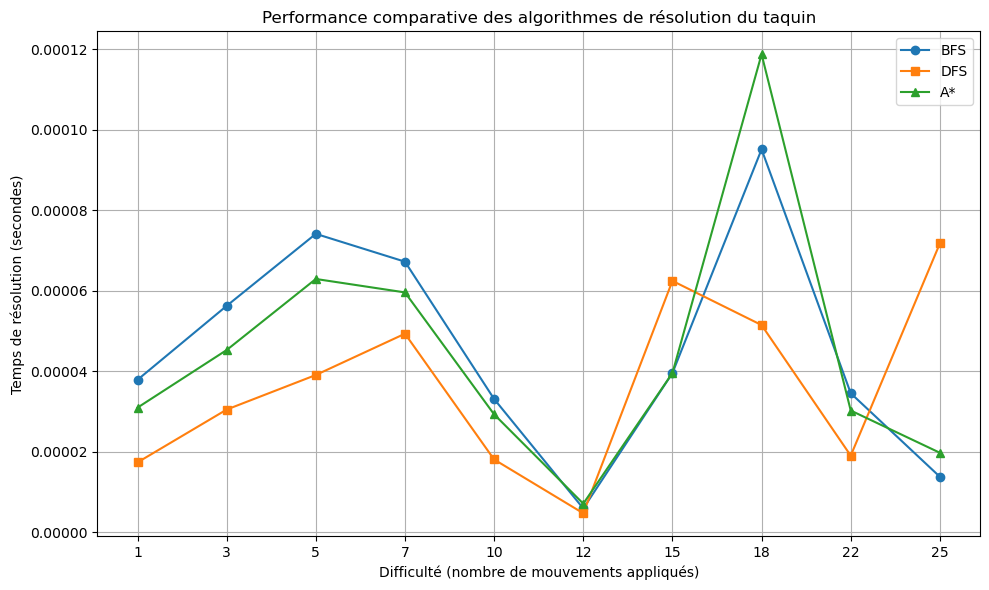

In [8]:
import time
import matplotlib.pyplot as plt

def measure_time(method, puzzle: State) -> float:
    start = time.time()
    method(puzzle)
    return time.time() - start

def main():
    scramble_levels = [1, 3, 5]# 7, 10, 12, 15, 18, 22, 25]
    dimension = 2

    bfs_times = []
    dfs_times = []
    astar_times = []
    labels = []

    for moves in scramble_levels:
        print(f"Génération du puzzle {dimension}*{dimension} avec difficulté (mouvements appliqués) : {moves}")
        puzzle = generate_by_scrambling(dimension, moves)
        labels.append(str(moves))

        bfs_times.append(measure_time(solve_bfs, puzzle))
        dfs_times.append(measure_time(solve_dfs, puzzle))
        astar_times.append(measure_time(solve_astar, puzzle))

    # Affichage du graphe
    plt.figure(figsize=(10, 6))
    x = range(len(scramble_levels))
    plt.plot(x, bfs_times, label='BFS', marker='o')
    plt.plot(x, dfs_times, label='DFS', marker='s')
    plt.plot(x, astar_times, label='A*', marker='^')

    plt.xticks(x, labels)
    plt.xlabel("Difficulté (nombre de mouvements appliqués)")
    plt.ylabel("Temps de résolution (secondes)")
    plt.title("Performance comparative des algorithmes de résolution du taquin")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
main()